## Étape 4 : Simulez un contrat de maintenance

Pour simuler un contrat de maintenance, nous allons suivre les étapes suivantes :

Charger et préparer les données.

Entraîner un modèle initial sur une période d'un an.

Simuler l'ajout de nouvelles données mensuellement et recalculer les clusters en utilisant le modèle initial.

Entraîner un nouveau modèle chaque mois et comparer les clusters obtenus avec ceux du modèle initial.

Utiliser l'Adjusted Rand Index (ARI) pour mesurer la stabilité des clusters.

Afficher l'évolution de l'ARI au fil du temps pour déterminer le moment où le modèle doit être réentraîné.

### 4.1  Limiter les données et ajouter une colonne 'date'

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

In [10]:
# Charger les données
data = pd.read_csv('rfm_results.csv')

In [12]:
# Limiter le nombre de lignes à 50000 jours pour éviter l'erreur OutOfBoundsDatetime
data = data.head(50000)

In [14]:
# Ajouter une colonne 'date' pour simuler les périodes
data['date'] = pd.date_range(start='2017-01-01', periods=len(data), freq='D')
data = data.sort_values('date')

### 4.2  Normaliser les données

In [17]:
from sklearn.preprocessing import StandardScaler

# Normaliser les données
features = ['recency', 'frequency', 'monetary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

### 4.3  Entraîner le modèle initial

In [20]:
from sklearn.cluster import KMeans

# Période d'entraînement initiale (1 an)
train_period = data[(data['date'] >= '2017-01-01') & (data['date'] < '2018-01-01')]
X_train = X_scaled[data.index.isin(train_period.index)]

# Entraîner le modèle K-means sur les données d'entraînement
kmeans_initial = KMeans(n_clusters=3, random_state=42)
kmeans_initial.fit(X_train)
initial_labels = kmeans_initial.labels_

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### 4.4  Simuler l'ajout de nouvelles données mensuellement

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

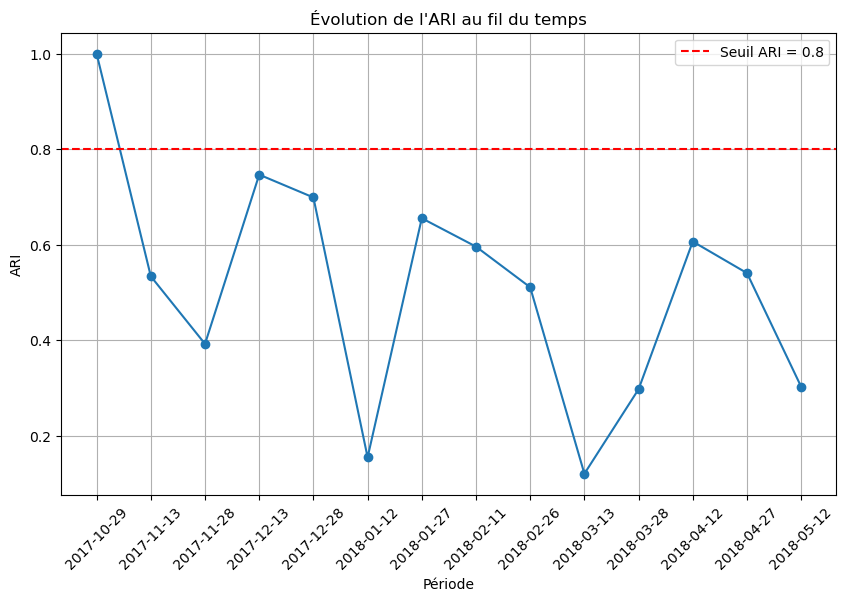

In [23]:
from sklearn.metrics import adjusted_rand_score

# Définir la période de test (ajout de données mensuellement)
test_period_start = '2017-10-29'
test_period_end = '2018-06-01'

# Initialiser une liste pour stocker les scores ARI
ari_scores = []
period_labels = []

# Initialiser les périodes
current_period_start = pd.to_datetime(test_period_start)
current_period_end = current_period_start + pd.DateOffset(days=15)

while current_period_end <= pd.to_datetime(test_period_end):
    # Séparer les données de la période actuelle
    current_period = data[(data['date'] >= current_period_start) & (data['date'] < current_period_end)]
    X_current = X_scaled[data.index.isin(current_period.index)]
    
    # Prédire les clusters en utilisant le modèle initial
    predicted_labels_initial = kmeans_initial.predict(X_current)
    
    # Entraîner un nouveau modèle sur les données de la période actuelle
    kmeans_new = KMeans(n_clusters=3, random_state=42)
    kmeans_new.fit(X_current)
    new_labels = kmeans_new.labels_
    
    # Calculer l'ARI entre les clusters prédits par le modèle initial et ceux du nouveau modèle
    ari = adjusted_rand_score(predicted_labels_initial, new_labels)
    ari_scores.append(ari)
    period_labels.append(current_period_start.strftime('%Y-%m-%d'))
    
    # Passer à la période suivante
    current_period_start = current_period_end
    current_period_end = current_period_start + pd.DateOffset(days=15)

# Afficher l'évolution de l'ARI au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(period_labels, ari_scores, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='Seuil ARI = 0.8')
plt.title('Évolution de l\'ARI au fil du temps')
plt.xlabel('Période')
plt.xticks(rotation=45)
plt.ylabel('ARI')
plt.legend()
plt.grid(True)
plt.show()

La segmentation doit être mise à jour tous les 15 jours